In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

from sklearn.ensemble import IsolationForest

from sklearn.svm import OneClassSVM

### Cargar el Dataset

In [2]:
filePath = "C:/Users/raul.blanco/Documents/4 - Personales/UBA/Repositorios/IA/Trabajo-Final/solar_wind.csv"
dF = pd.read_csv(filepath_or_buffer=filePath, header=0, sep=",")

df_A = dF.loc[dF['period']=='train_a']
df_A = df_A.dropna()

### Preprocesamiento

Partiendo de la hipótesis de que el dataset no contiene valores anómalos, se deben ingresar manualmente.
Para esto, se selecciona la variable "bt" que corresponde con la magnitud total del campo magnético interplanetario [nT].

Se define la variable "anomaly_factor" para determinar la cantidad de valores anómalos a incorporar al dataset.

Al dataset se le agrega un feature "class" cuyo valor será 1 si el registro contiene un valor anómalo y 0 si el valor del registro es el original del dataset.

Se divide el Dataset en Train y Test

In [3]:
train_data = df_A.sample(frac=0.8, random_state=0)
test_data = df_A.drop(train_data.index)

In [4]:
features = ['bt']
anomaly_factor = 0.17
# Crear una copia del DataFrame para no modificar el original
df_new = train_data.copy()

for a in features:
  num_replace = int(train_data[a].size * anomaly_factor)

  # Obtener una muestra aleatoria de índices de fila para reemplazar
  replace_idx = np.random.choice(train_data.index, size=num_replace, replace=False)

  # Reemplazar los valores seleccionados con valores aleatorios entre -90 y 1050
  #new_values = np.random.uniform(-90, 1050, size=num_replace)
  new_values = np.random.uniform(0, 75, size=num_replace)
  df_new.loc[replace_idx, a] = new_values

  # Crear la columna "class" con los valores correspondientes
  df_new.loc[train_data[a] != df_new[a], 'class'] = 1
  df_new.loc[train_data[a] == df_new[a], 'class'] = 0
  train_data = df_new
  

Ingreso anomalías en test (ingreso menor cantidad de anomalías)

In [9]:
features = ['bt']
anomaly_factor = 0.012
# Crear una copia del DataFrame para no modificar el original
df_new_test = test_data.copy()

for a in features:
  num_replace = int(test_data[a].size * anomaly_factor)

  # Obtener una muestra aleatoria de índices de fila para reemplazar
  replace_idx = np.random.choice(test_data.index, size=num_replace, replace=False)

  # Reemplazar los valores seleccionados con valores aleatorios entre -90 y 1050
  new_values = np.random.uniform(0, 75, size=num_replace)
  df_new_test.loc[replace_idx, a] = new_values

  # Crear la columna "class" con los valores correspondientes
  df_new_test.loc[test_data[a] != df_new_test[a], 'class'] = 1
  df_new_test.loc[test_data[a] == df_new_test[a], 'class'] = 0
  test_data = df_new_test

In [12]:
count = (test_data['class'] == 1).sum()
count1 = (test_data['class'] == 0).sum()
relacion = 100* count/count1
print(f'El número de anomalias en test es {count} y {count1} son valores normales')
print('La relación es: ', relacion,'%')

El número de anomalias en test es 3346 y 275565 son valores normales
La relación es:  1.2142325767060402 %


#### Verificación de registros con anomalidades introducidas

In [13]:
train_timedelta = train_data[['timedelta']]
test_timedelta = test_data[['timedelta']]

Se eliminan los features que no se tendran en cuenta en el entrenamiento del modelo

In [14]:
y = test_data['class']
y_full = test_data
train_data = train_data.drop(["timedelta", "period", "source", 'class'], axis=1)
test_data = test_data.drop(["timedelta", "period", "source", 'class'], axis=1)
y_full = y_full.to_numpy()

Normalización del dataset

In [15]:
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [24]:
select = int(input("Presione 1 para LSTM Autoencoder, 2 para Restricted Boltzmann Machine, 3 para Isolation Fores, 4 para Support Vector Machines"))
if select == 1: ### LSTM AUTOENCODER ###
    train_data_LSTM = train_data.reshape(train_data.shape[0],1,train_data.shape[1])
    test_data_LSTM = test_data.reshape(test_data.shape[0],1,test_data.shape[1])

    #Modelo
    input_dim = train_data_LSTM.shape[2]
    timesteps = 1
    inputs = Input(shape=(timesteps, input_dim))
    encoded = LSTM(64, activation='relu', return_sequences=True)(inputs)
    encoded = LSTM(32, activation='relu', return_sequences=True)(inputs)
    encoded = LSTM(16, activation='relu', return_sequences=False)(encoded)
    decoded = RepeatVector(timesteps)(encoded)
    decoded = LSTM(16, activation='relu', return_sequences=True)(decoded)
    decoded = LSTM(32, activation='relu', return_sequences=True)(decoded)
    decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
    decoded = LSTM(input_dim, activation='linear', return_sequences=True)(decoded)
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    #Entreno el modelo
    autoencoder.fit(train_data_LSTM, train_data_LSTM, epochs=10, batch_size=320, validation_split=0.1)

elif select == 2: ### RBM ###
    #Modelo
    model_rbm = Sequential()
    model_rbm.add(Dense(20, input_shape=(train_data.shape[1],), activation='sigmoid'))
    model_rbm.add(Dense(train_data.shape[1], activation='sigmoid'))
    model_rbm.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
    #Entreno el modelo
    model_rbm.fit(train_data, train_data, epochs=10, batch_size=32, verbose=1, validation_split=0.1)

elif select == 3: ### Isolation Forest ###
    #Modelo
    model_if = IsolationForest(n_estimators=100, contamination='auto', random_state=0)
    #Entreno el modelo
    model_if.fit(train_data,train_data)

elif select == 4: ### Support Vector Machines ###
    #Modelo
    model_svm = OneClassSVM(kernel='rbf', nu=0.01)
    #Entreno el modelo
    model_svm.fit(train_data)
else:
    print('Debe seleccionar un modelo')

Epoch 1/10
31378/31378 [==============================] - 27s 847us/step - loss: 0.5779 - val_loss: 0.5762
Epoch 2/10
31378/31378 [==============================] - 26s 834us/step - loss: 0.5746 - val_loss: 0.5761
Epoch 3/10
31378/31378 [==============================] - 28s 876us/step - loss: 0.5744 - val_loss: 0.5757
Epoch 4/10
31378/31378 [==============================] - 34s 1ms/step - loss: 0.5743 - val_loss: 0.5756
Epoch 5/10
31378/31378 [==============================] - 34s 1ms/step - loss: 0.5740 - val_loss: 0.5753
Epoch 6/10
31378/31378 [==============================] - 31s 972us/step - loss: 0.5739 - val_loss: 0.5752
Epoch 7/10
31378/31378 [==============================] - 34s 1ms/step - loss: 0.5739 - val_loss: 0.5753
Epoch 8/10
31378/31378 [==============================] - 33s 1ms/step - loss: 0.5739 - val_loss: 0.5755
Epoch 9/10
31378/31378 [==============================] - 32s 1ms/step - loss: 0.5739 - val_loss: 0.5753
Epoch 10/10
31378/31378 [======================

## Modelos

### LSTM Autoencoder

In [237]:
predictions_LSTM = autoencoder.predict(test_data_LSTM)

8716/8716 [==============================] - 15s 2ms/step


Evaluación del modelo LSTM Autoencoder

Se comparan las predicciones con los valores reales de "class" para generar una matriz de confusión para evaluar el modelo

In [402]:
#threshold_LSTM = 0.4
threshold_LSTM = float(input("Modelo LSTM Autoencoder. Ingrese el Threshold a utilizar: "))
predictions_LSTM[predictions_LSTM >= threshold_LSTM] = 1
predictions_LSTM[predictions_LSTM < threshold_LSTM] = 0

In [239]:
predictions_LSTM = predictions_LSTM.reshape(predictions_LSTM.shape[0], predictions_LSTM.shape[2])
test_data = test_data.reshape(test_data_LSTM.shape[0], test_data_LSTM.shape[2])
confusion_matrix = pd.crosstab(y_full[:, -1], predictions_LSTM[:, 10], rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

Predicted     0.0   1.0
Actual                 
0.0        265396  5148
1.0          2072  6295


In [240]:
pd_predictions_LSTM = pd.DataFrame(predictions_LSTM)
column_10 = predictions_LSTM[:, 10]
is_one_LSTM = column_10 ==1
# Asignar 1 a los elementos que sean True y 0 a los elementos que sean False
has_ones_LSTM = np.where(is_one_LSTM, 1, 0)

In [241]:
has_ones_LSTM_pd = pd.DataFrame(has_ones_LSTM, columns=['class'])
count = (has_ones_LSTM_pd['class'] == 1).sum()
count1 = (has_ones_LSTM_pd['class'] == 0).sum()
print(f'El número de anomalias es {count} y {count1} son valores normales')

El número de anomalias es 11443 y 267468 son valores normales


In [242]:
new_column_LSTM = has_ones_LSTM
# Agregar la nueva columna al final del ndarray original
predictions_class_LSTM = np.hstack((predictions_LSTM, new_column_LSTM.reshape(-1, 1)))

In [243]:
pd_predictions_LSTM = pd.DataFrame(predictions_class_LSTM)

In [244]:
pd_test_data = pd.DataFrame(test_data)

In [245]:
from sklearn.metrics import classification_report
 
print(classification_report(predictions_class_LSTM[:,14], y))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99    267468
         1.0       0.75      0.55      0.64     11443

    accuracy                           0.97    278911
   macro avg       0.87      0.77      0.81    278911
weighted avg       0.97      0.97      0.97    278911



In [246]:
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import confusion_matrix
class visualization:
  labels = ["Normal","Anomal"]
  def draw_confusion_matrix(self, y, ypred):
    matrix = confusion_matrix(y, ypred)

    plt.figure(figsize=(10,8))
    colors=["orange", "green"]
    sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("Realidad")
    plt.xlabel("Predicción")
    plt.savefig("confusion_matrix.jpg", dpi=300, bbox_inches='tight')
    plt.show()

In [247]:
y_pd = pd.DataFrame(y, columns = ['class'])
count = (y_pd['class'] == 1).sum()
print(f'El número de anomalias reales es {count}')

El número de anomalias reales es 8367


In [248]:
predictions_class_LSTM_pd  = pd.DataFrame(predictions_class_LSTM, columns = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','class'])
count = (predictions_class_LSTM_pd['class'] == 1).sum()
print(f'El número de anomalias predecidas es {count}')

El número de anomalias predecidas es 11443


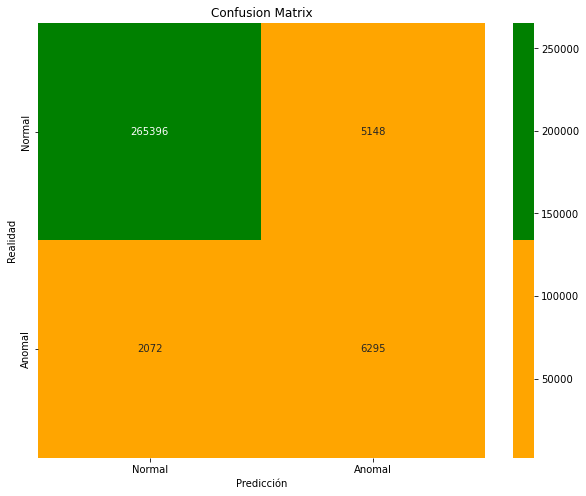

In [249]:
viz = visualization()
viz.draw_confusion_matrix(y_pd, predictions_class_LSTM[:,14])

In [250]:
test_timedelta.reset_index(inplace=True)

In [251]:
predictions_class_LSTM_pd = pd.concat([test_timedelta, predictions_class_LSTM_pd], axis = 1 , join = "inner")

In [252]:
anomalies_LSTM = predictions_class_LSTM_pd.loc[predictions_class_LSTM_pd['class'] == 1.0,['timedelta']]

In [253]:
anomalies_LSTM

,timedelta
46,0 days 05:18:00
108,0 days 11:11:00
109,0 days 11:12:00
166,0 days 20:46:00
223,1 days 00:47:00
...,...
278780,1200 days 12:21:00
278781,1200 days 12:22:00
278817,1200 days 15:28:00
278887,1200 days 21:23:00


### RBM

Creación del modelo

Entreno el modelo Restricted Boltzmann Machine

In [393]:
predictions_rbm = model_rbm.predict(test_data)

8716/8716 [==============================] - 5s 585us/step


Evaluación del modelo rbm

In [401]:
threshold_rbm = float(input("Modelo Restricted Boltzmann Machine. Ingrese el Threshold a utilizar: "))
#threshold_rbm = 0.8
predictions_rbm[predictions_rbm >= threshold_rbm] = 1
predictions_rbm[predictions_rbm < threshold_rbm] = 0

In [399]:
#y_full = y_full.to_numpy()
confusion_matrix = pd.crosstab(y_full[:, -1], predictions_rbm[:, 10], rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

Predicted     0.0   1.0
Actual                 
0.0        267732  2812
1.0          2402  5965


In [259]:
pd_predictions = pd.DataFrame(predictions_rbm)
column_10_rbm = predictions_rbm[:, 10]
is_one_rbm = column_10_rbm ==1
# Asignar 1 a los elementos que sean True y 0 a los elementos que sean False
has_ones_rbm = np.where(is_one_rbm, 1, 0)

In [260]:
has_ones_rbm_pd = pd.DataFrame(has_ones_rbm, columns=['class'])
count = (has_ones_rbm_pd['class'] == 1).sum()
count1 = (has_ones_rbm_pd['class'] == 0).sum()
print(f'El número de anomalias predecidas es {count} y {count1} son valores normales')

El número de anomalias predecidas es 8777 y 270134 son valores normales


In [261]:
new_column_rbm = has_ones_rbm
new_column_rbm.shape

(278911,)

In [262]:
predictions_class_rbm = np.hstack((predictions_rbm, new_column_rbm.reshape(-1, 1)))

In [263]:
pd_predictions_rbm = pd.DataFrame(predictions_class_rbm)

In [264]:
from sklearn.metrics import classification_report
 
print(classification_report(predictions_class_rbm[:,14], y))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    270134
         1.0       0.71      0.68      0.70      8777

    accuracy                           0.98    278911
   macro avg       0.85      0.84      0.84    278911
weighted avg       0.98      0.98      0.98    278911



In [265]:
predictions_class_rbm_pd  = pd.DataFrame(predictions_class_rbm, columns = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','class'])
count = (predictions_class_rbm_pd['class'] == 1).sum()
print(f'El número de anomalias predecidas es {count}')

El número de anomalias predecidas es 8777


In [266]:
predictions_class_rbm

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [366]:
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import confusion_matrix
class visualization:
  labels = ["Normal","Anomal"]
  def draw_confusion_matrix(self, y, ypred):
    matrix = confusion_matrix(y, ypred)

    plt.figure(figsize=(10,8))
    colors=["orange", "green"]
    sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("Realidad")
    plt.xlabel("Predicción")
    plt.savefig("confusion_matrix.jpg", dpi=300, bbox_inches='tight')
    plt.show()

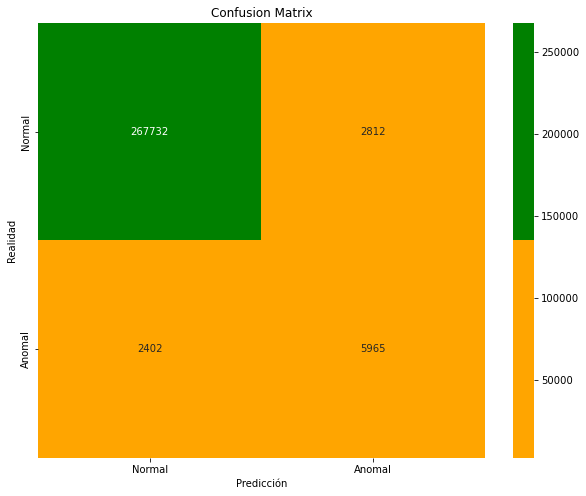

In [367]:
viz = visualization()
viz.draw_confusion_matrix(y_pd, predictions_class_rbm[:,14])

In [269]:
predictions_class_rbm_pd = pd.concat([test_timedelta, predictions_class_rbm_pd], axis = 1 , join = "inner")

In [270]:
anomalies_rbm = predictions_class_rbm_pd.loc[predictions_class_rbm_pd['class'] == 1.0,['timedelta']]

In [271]:
anomalies_rbm

,timedelta
46,0 days 05:18:00
108,0 days 11:11:00
109,0 days 11:12:00
166,0 days 20:46:00
223,1 days 00:47:00
...,...
278780,1200 days 12:21:00
278781,1200 days 12:22:00
278817,1200 days 15:28:00
278887,1200 days 21:23:00


### Isolation Forest

Creación del modelo

Entreno el modelo

In [291]:
predictions_if = model_if.predict(test_data)

Evaluación del modelo Isolation Forest

In [292]:
threshold_if = 0.5
predictions_if[predictions_if >= threshold_if] = 1
predictions_if[predictions_if < threshold_if] = 0

In [293]:
#y_full = y_full.to_numpy()
confusion_matrix = pd.crosstab(y_full[:, -1], predictions_if, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

Predicted      0       1
Actual                  
0.0        23362  247182
1.0         1785    6582


In [294]:
pd_predictions_if = pd.DataFrame(predictions_if, columns=['class'])
count = (pd_predictions_if['class'] == 1).sum()
count1 = (pd_predictions_if['class'] == 0).sum()
print(f'El número de anomalias predecidas es {count} y {count1} valores normales')

El número de anomalias predecidas es 253764 y 25147 valores normales


In [295]:
print(classification_report(pd_predictions_if, y))

              precision    recall  f1-score   support

           0       0.09      0.93      0.16     25147
           1       0.79      0.03      0.05    253764

    accuracy                           0.11    278911
   macro avg       0.44      0.48      0.10    278911
weighted avg       0.72      0.11      0.06    278911



In [296]:
y_pd = pd.DataFrame(y, columns = ['class'])
count = (y_pd['class'] == 1).sum()
print(f'El número de anomalias reales es {count}')

El número de anomalias reales es 8367


In [297]:
count = (pd_predictions_if['class'] == 1).sum()
print(f'El número de anomalias predecidas es {count}')

El número de anomalias predecidas es 253764


In [298]:
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import confusion_matrix
class visualization:
  labels = ["Normal","Anomal"]
  def draw_confusion_matrix(self, y, ypred):
    matrix = confusion_matrix(y, ypred)

    plt.figure(figsize=(10,8))
    colors=["orange", "green"]
    sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("Realidad")
    plt.xlabel("Predicción")
    plt.savefig("confusion_matrix.jpg", dpi=300, bbox_inches='tight')
    plt.show()

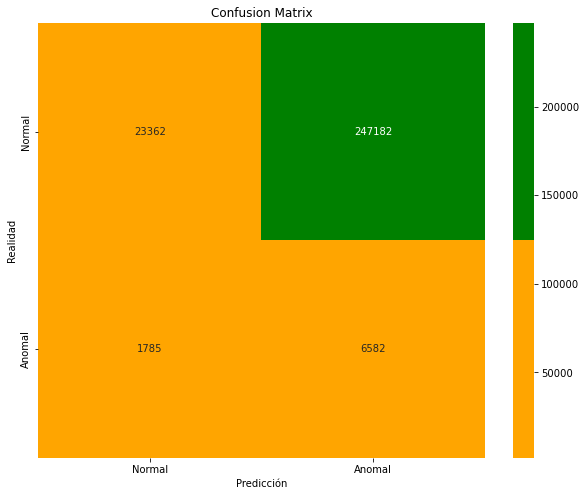

In [299]:
viz = visualization()
viz.draw_confusion_matrix(y_pd, pd_predictions_if)

In [300]:
predictions_class_if_pd = pd.concat([test_timedelta, pd_predictions_if], axis = 1 , join = "inner")

In [301]:
predictions_class_if_pd

,index,timedelta,class
0,3,0 days 00:03:00,1
1,4,0 days 00:04:00,1
2,11,0 days 00:11:00,1
3,16,0 days 00:16:00,1
4,27,0 days 00:27:00,1
...,...,...,...
278906,1729419,1200 days 23:39:00,1
278907,1729427,1200 days 23:47:00,1
278908,1729429,1200 days 23:49:00,1
278909,1729434,1200 days 23:54:00,1


In [302]:
anomalies_if = predictions_class_if_pd.loc[predictions_class_if_pd['class'] == 1.0,['timedelta']]

In [303]:
anomalies_if

,timedelta
0,0 days 00:03:00
1,0 days 00:04:00
2,0 days 00:11:00
3,0 days 00:16:00
4,0 days 00:27:00
...,...
278906,1200 days 23:39:00
278907,1200 days 23:47:00
278908,1200 days 23:49:00
278909,1200 days 23:54:00


### Support Vector Machines

Creación del modelo

Entreno el modelo

In [306]:
predictions_svm = model_svm.predict(test_data)

Evaluación del Modelo Support Vector Machines

In [307]:
predictions_svm[predictions_svm == 1] = 0
predictions_svm[predictions_svm == -1] = 1

In [308]:
confusion_matrix = pd.crosstab(y_full[:, -1], predictions_svm, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

Predicted       0     1
Actual                 
0.0        268180  2364
1.0          8204   163


In [309]:
pd_predictions_svm = pd.DataFrame(predictions_svm, columns=['class'])
count = (pd_predictions_svm['class'] == 1).sum()
count1 = (pd_predictions_svm['class'] == 0).sum()
print(f'El número de anomalias predecidas es {count} y {count1} valores normales')

El número de anomalias predecidas es 2527 y 276384 valores normales


In [310]:
print(classification_report(pd_predictions_svm, y))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98    276384
           1       0.02      0.06      0.03      2527

    accuracy                           0.96    278911
   macro avg       0.51      0.52      0.51    278911
weighted avg       0.98      0.96      0.97    278911



In [311]:
y_pd = pd.DataFrame(y, columns = ['class'])
count = (y_pd['class'] == 1).sum()
print(f'El número de anomalias reales es {count}')

El número de anomalias reales es 8367


In [312]:
count = (pd_predictions_svm['class'] == 1).sum()
print(f'El número de anomalias predecidas es {count}')

El número de anomalias predecidas es 2527


In [313]:
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import confusion_matrix
class visualization:
  labels = ["Normal","Anomal"]
  def draw_confusion_matrix(self, y, ypred):
    matrix = confusion_matrix(y, ypred)

    plt.figure(figsize=(10,8))
    colors=["orange", "green"]
    sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("Realidad")
    plt.xlabel("Predicción")
    plt.savefig("confusion_matrix.jpg", dpi=300, bbox_inches='tight')
    plt.show()

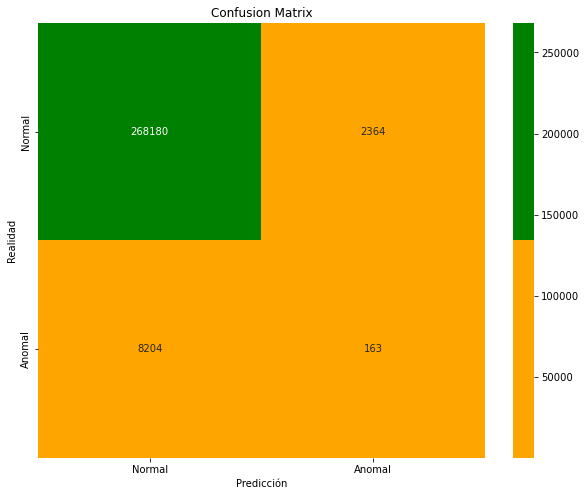

In [314]:
viz = visualization()
viz.draw_confusion_matrix(y_pd, pd_predictions_svm)

In [315]:
anomalies_svm = pd.concat([test_timedelta, pd_predictions_svm], axis = 1 , join = "inner")

In [316]:
anomalies_svm

,index,timedelta,class
0,3,0 days 00:03:00,0
1,4,0 days 00:04:00,0
2,11,0 days 00:11:00,0
3,16,0 days 00:16:00,0
4,27,0 days 00:27:00,0
...,...,...,...
278906,1729419,1200 days 23:39:00,0
278907,1729427,1200 days 23:47:00,0
278908,1729429,1200 days 23:49:00,0
278909,1729434,1200 days 23:54:00,0


## Gráficos y evaluación con AUC

In [317]:
clase = y_full[:,-1].astype(int)

In [318]:
from sklearn.metrics import roc_auc_score

# Calcular el AUC para cada modelo utilizando la función roc_auc_score() de la biblioteca scikit-learn
LSTM_auc = roc_auc_score(clase, predictions_class_LSTM[:,14])
rbm_auc = roc_auc_score(clase, predictions_class_rbm[:,14])
if_auc = roc_auc_score(clase, predictions_if)
svm_auc = roc_auc_score(clase, predictions_svm)
print("AUC de LSTM Autoencoder:", LSTM_auc)
print("AUC de Restricted Bolztmann Machine:", rbm_auc)
print("AUC de Isolation Forest:", if_auc)
print("AUC de Suport Vector Machines:", svm_auc)

AUC de LSTM Autoencoder: 0.8666660678086269
AUC de Restricted Bolztmann Machine: 0.851262965453267
AUC de Isolation Forest: 0.4365069143665093
AUC de Suport Vector Machines: 0.5053716726809401


In [319]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [320]:
rbm_fpr, rbm_tpr, _ = roc_curve(clase, predictions_class_rbm[:,14])
rbm_auc = auc(rbm_fpr, rbm_tpr)

In [321]:
LSTM_fpr, LSTM_tpr, _ = roc_curve(clase, predictions_class_LSTM[:,14])
LSTM_auc = auc(LSTM_fpr, LSTM_tpr)

In [322]:
if_fpr, if_tpr, _ = roc_curve(clase, predictions_if)
if_auc = auc(if_fpr, if_tpr)

In [323]:
svm_fpr, svm_tpr, _ = roc_curve(clase, predictions_svm)
svm_auc = auc(svm_fpr, svm_tpr)

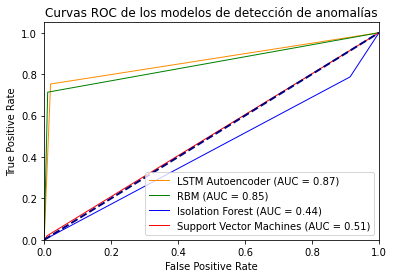

In [324]:
plt.figure()
plt.plot(LSTM_fpr, LSTM_tpr, color='darkorange', lw=1, label='LSTM Autoencoder (AUC = %0.2f)' % LSTM_auc)
plt.plot(rbm_fpr, rbm_tpr, color='green', lw=1, label='RBM (AUC = %0.2f)' % rbm_auc)
plt.plot(if_fpr, if_tpr, color='blue', lw=1, label='Isolation Forest (AUC = %0.2f)' % if_auc)
plt.plot(svm_fpr, svm_tpr, color='red', lw=1, label='Support Vector Machines (AUC = %0.2f)' % svm_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC de los modelos de detección de anomalías')
plt.legend(loc="lower right")
plt.show()

## Reporte en PDF

In [326]:
test_data_pd = pd.DataFrame(test_data, columns=['bx_gse', 'by_gse', 'bz_gse', 'theta_gse',
       'phi_gse', 'bx_gsm', 'by_gsm', 'bz_gsm', 'theta_gsm', 'phi_gsm', 'bt',
       'density', 'speed', 'temperature'])
test_data_pd = pd.concat([test_timedelta, test_data_pd], axis = 1 , join = "inner")

In [333]:
output = test_data_pd[test_data_pd['timedelta'].isin(anomalies_rbm['timedelta'])]
output = output.round(3)

In [336]:
output = output.drop(['index'], axis=1)

In [392]:
from reportlab.lib.pagesizes import A4
from reportlab.lib.units import inch
from reportlab.pdfgen import canvas
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.platypus import Table, TableStyle

pdf = canvas.Canvas("Reporte de Anomalías.pdf", pagesize=A4)
page_width, page_height = A4
inch = 72  #32
df = output

data = [df.columns.tolist()] + df.values.tolist()

styles = getSampleStyleSheet()
style_table = TableStyle([
    ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
    ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
    ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
    ('FONTSIZE', (0, 0), (-1, 0), 6),
    ('BOTTOMPADDING', (0, 0), (-1, 0),12),
    ('BACKGROUND', (0, 1), (-1, -1), colors.lightgreen),
    ('GRID', (0, 0), (-1, -1), 1, colors.black),
    ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
    ('VALIGN', (0, 0), (-1, -1), 'MIDDLE'),
    ('FONTNAME', (0, 1), (-1, -1), 'Helvetica'),
    ('FONTSIZE', (0, 1), (-1, -1), 6),
    ('BOTTOMPADDING', (0, 1), (-1, -1), 6),
])

num_rows = len(data)
num_cols = len(data[0])

max_rows_per_page = int((page_height - 5.5 * inch) / (12 * 1.2)) - 1

num_pages = int(num_rows / max_rows_per_page) + 1

for page in range(num_pages):
    # Título en la primera página
    if page == 0:
        pdf.setFont("Helvetica-Bold", 16)
        pdf.drawString(inch, page_height - inch, "Reporte de anomalías detectadas")
        pdf.drawString(inch, page_height - inch+18, "INVAP")

    # Agrego la matriz de confusión
        pdf.setFont("Helvetica", 11)
        pdf.drawString(inch, page_height - inch-20, "La matriz de confusión obtenida con el modelo seleccionado es la siguiente:")
        pdf.drawImage("confusion_matrix.jpg", 100, 360, width=5*inch, height=5*inch)
        #pdf.drawImage("confusion_matrix.jpg", 100, 400, width=350, height=350) #, width=3*inch, height=3*inch)

    # Agrego resultados de AUC
        pdf.drawString(inch, 300, f"AUC de Restricted Bolztmann Machine: {rbm_auc}")
        pdf.setFont("Helvetica", 8)
        pdf.drawString(inch, inch+24, "Informe de anormalidades detectadas")
        pdf.drawString(inch, inch+12, "Especialización en Inteligencia Artificial")
        pdf.drawString(inch, inch, "Ing. Raúl Blanco Elicabe")
        pdf.drawString(inch+420, inch, f"Página {page+1}")
        pdf.showPage()
    if page > 0:
    # Pie de página en todas las páginas
        pdf.setFont("Helvetica", 8)
        pdf.drawString(inch, inch+24, "Informe de anormalidades detectadas")
        pdf.drawString(inch, inch+12, "Especialización en Inteligencia Artificial")
        pdf.drawString(inch, inch, "Ing. Raúl Blanco Elicabe")
        pdf.drawString(inch+420, inch, f"Página {page+1}")


        start_row = (page-1) * max_rows_per_page
        end_row = min((page) * max_rows_per_page, num_rows)

        page_data = data[start_row:end_row]

        table = Table(page_data,colWidths=[0.75 * inch, 0.4 * inch, 0.4 * inch, 0.4 * inch, 0.4 * inch, 0.4 * inch, 0.4 * inch, 0.4 * inch, 0.4 * inch, 0.4 * inch, 0.4 * inch, 0.4 * inch, 0.4 * inch, 0.4 * inch, 0.4 * inch])
        
        table.setStyle(style_table)

        table.wrapOn(pdf, page_width - 2 * inch, page_height - 2 * inch)
        table.drawOn(pdf, inch, page_height - 10 * inch - 12 * 1.2)

        if page < num_pages - 1:
            pdf.showPage()

pdf.save()


In [339]:
output.to_csv('output_anomalies.csv')